In [1]:
!pip install fiftyone

In [2]:
!wandb login

wandb: Currently logged in as: matthiascr (matthiascr-hpi-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
import wandb


import sys
from pathlib import Path

project_root = Path("..").resolve()
sys.path.append(str(project_root))
from src import datasets
from src import training
from src import visualization
from src import models

/home/matthias/miniconda3/envs/CompVision/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

As we did in the previous notebooks we start by loading the data as a fiftyone dataset from huggingface.

In [5]:
IMG_SIZE = 64
BATCH_SIZE = 32

In [6]:
# load fiftyone dataset from huggingface
dataset = load_from_hub(
    "MatthiasCr/multimodal-shapes-subset", 
    name="multimodal-shapes-subset",
    # fewer workers and greater batch size to hopefully avoid getting rate limited
    num_workers=2,
    batch_size=1000,
    overwrite=True,
)

Loading dataset
Importing samples...
 100% |███████████████| 4000/4000 [49.9ms elapsed, 0s remaining, 80.2K samples/s]   


In [7]:
img_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

train_dataset = datasets.MultimodalDataset(dataset, "train", img_transforms)
val_dataset = datasets.MultimodalDataset(dataset, "val", img_transforms)

# use generator with fixed seed for reproducible shuffling
generator = torch.Generator()
generator.manual_seed(51)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, generator=generator)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# number of train batches, needed for learning rate scheduling
steps_per_epoch = len(train_dataloader)

## Baseline Lidar Classifier

We first train a single modal classifier that only uses lidar data to do the cube/sphere classification. This `LidarClassifier` consists of an embedder and a classification head. The purpose of this model is to define an embedding space for lidar data and to have a classifier head that works on these embeddings. We will later project image embeddings onto this lidar embedding space so that we can use this classifier head (without the embedder) for classification of image data.

In [ ]:
lidar_classifier = models.LidarClassifier().to(device)
lidar_classifier_num_params = sum(p.numel() for p in lidar_classifier.parameters())
epochs = 20
start_lr = 1e-4
end_lr = 1e-6

optim = Adam(lidar_classifier.parameters(), lr=start_lr)
scheduler = CosineAnnealingLR(optim, T_max=epochs * steps_per_epoch, eta_min=end_lr)
loss_func = nn.BCEWithLogitsLoss()

In [9]:
def apply_classifier_model(model, batch):
    # only lidar data used
    _, inputs_xyz, target = batch
    inputs_xyz = inputs_xyz.to(device)
    target = target.to(device)
    outputs = model(raw_data=inputs_xyz)
    return outputs, target

wandb: Currently logged in as: matthiascr (matthiascr-hpi-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


All random seeds set to 51 for reproducibility
epoch 0 train loss: 0.6944200873374939
epoch 0 valid loss: 0.6924511790275574 accuracy: 0.5208333333333334
Found and saved better weights for the model
epoch 1 train loss: 0.6935635697841644
epoch 1 valid loss: 0.692696750164032 accuracy: 0.5208333333333334
epoch 2 train loss: 0.6935997080802917
epoch 2 valid loss: 0.6931818028291067 accuracy: 0.4791666666666667
epoch 3 train loss: 0.6937699210643768
epoch 3 valid loss: 0.693220779299736 accuracy: 0.4791666666666667
epoch 4 train loss: 0.6938732838630677
epoch 4 valid loss: 0.693504735827446 accuracy: 0.4791666666666667
epoch 5 train loss: 0.6938415789604186
epoch 5 valid loss: 0.6933414687712988 accuracy: 0.4791666666666667
epoch 6 train loss: 0.6936163854598999
epoch 6 valid loss: 0.6929313043753306 accuracy: 0.5208333333333334
epoch 7 train loss: 0.6932417571544647
epoch 7 valid loss: 0.6937532275915146 accuracy: 0.4791666666666667
epoch 8 train loss: 0.6933254277706147
epoch 8 valid lo

learning_rate,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
train_loss,██████████████▆▄▃▂▁▁
valid_accuracy,▂▂▁▁▁▁▂▁▁▂▁▂▂▅▆▇▇███
valid_loss,█████████████▇▄▃▂▁▁▁
learning_rate,0.0
total_train_time_sec,109.86693
train_loss,0.15833


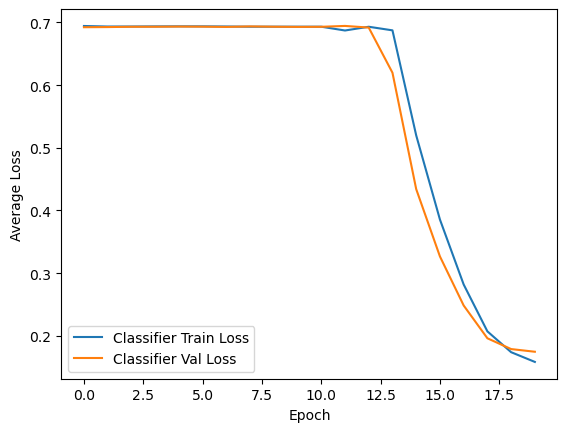

In [10]:
run = training.initWandbRun(
    "", epochs, BATCH_SIZE, lidar_classifier_num_params, "Adam", "Cosine Annealing", start_lr, end_lr
)

classifier_train_loss, classifier_val_loss = training.train_model(
    lidar_classifier, 
    optim, 
    apply_classifier_model, 
    loss_func, 
    epochs, 
    train_dataloader, 
    val_dataloader, 
    device, 
    run, 
    scheduler=scheduler, 
    output_name="lidar_classifier"
)

run.finish()

visualization.plot_loss(epochs,
    {
        "Classifier Train Loss": classifier_train_loss,
        "Classifier Val Loss": classifier_val_loss
    }
)

Now load the best checkpoint and freeze the model so we can use it later without altering it.

In [11]:
lidar_classifier = models.LidarClassifier()
lidar_classifier.load_state_dict(
    torch.load("../checkpoints/lidar_classifier.pt", map_location=device))
lidar_classifier = lidar_classifier.to(device)

for param in lidar_classifier.parameters():
    param.requires_grad = False
lidar_classifier.eval()

LidarClassifier(
  (embedder): Sequential(
    (0): Conv2d(4, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=3200, out_features=200, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, o

## CILP Model

In [12]:
cilp_model = models.ContrastivePretraining(batch_size=BATCH_SIZE).to(device)
cilp_num_params = sum(p.numel() for p in cilp_model.parameters())
epochs = 10
lr = 1e-4

optim = Adam(cilp_model.parameters(), lr=lr)

In [13]:
def apply_cilp_model(model, batch):
    # cilp model doesn't use the class information
    inputs_rgb, inputs_xyz, _ = batch
    inputs_rgb = inputs_rgb.to(device)
    inputs_xyz = inputs_xyz.to(device)
    logits_per_img, logits_per_lidar = model(inputs_rgb, inputs_xyz)
    return logits_per_img, logits_per_lidar

loss_img = nn.CrossEntropyLoss()
loss_lidar = nn.CrossEntropyLoss()
ground_truth = torch.arange(BATCH_SIZE, dtype=torch.long).to(device)

def cilp_loss(logits_per_img, logits_per_lidar):
    return (loss_img(logits_per_img, ground_truth) + loss_lidar(logits_per_lidar, ground_truth)) / 2

All random seeds set to 51 for reproducibility
epoch 0 train loss: 3.3669033813476563
epoch 0 valid loss: 3.218193014462789
Found and saved better weights for the model
epoch 1 train loss: 3.1549267959594727
epoch 1 valid loss: 3.0982122818628945
Found and saved better weights for the model
epoch 2 train loss: 3.083999366760254
epoch 2 valid loss: 3.0627939105033875
Found and saved better weights for the model
epoch 3 train loss: 3.0611853122711183
epoch 3 valid loss: 3.051377793153127
Found and saved better weights for the model
epoch 4 train loss: 3.0519310522079466
epoch 4 valid loss: 3.045098125934601
Found and saved better weights for the model
epoch 5 train loss: 3.0487776708602907
epoch 5 valid loss: 3.042982300122579
Found and saved better weights for the model
epoch 6 train loss: 3.0425818157196045
epoch 6 valid loss: 3.0353402694066367
Found and saved better weights for the model
epoch 7 train loss: 3.037868633270264
epoch 7 valid loss: 3.034019966920217
Found and saved bette

train_loss,█▄▂▂▁▁▁▁▁▁
valid_loss,█▄▂▂▂▂▁▁▁▁
total_train_time_sec,103.00764
train_loss,3.03115


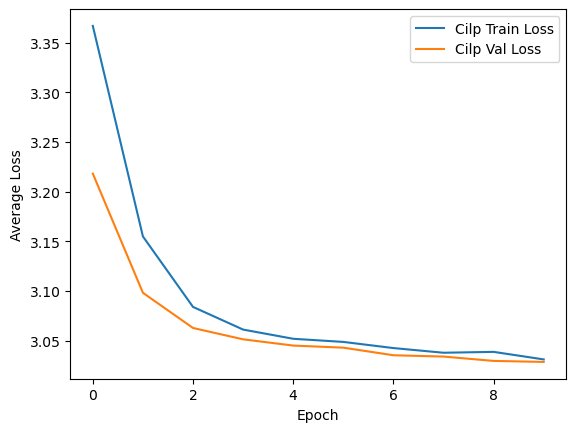

In [14]:
run = training.initWandbRun(
    "", epochs, BATCH_SIZE, cilp_num_params, "Adam", "", lr, lr
)

cilp_train_loss, cilp_val_loss = training.train_model(
    cilp_model, 
    optim,
    apply_cilp_model, 
    cilp_loss, 
    epochs, 
    train_dataloader, 
    val_dataloader, 
    device, 
    run, 
    scheduler=None, 
    output_name="cilp", 
    calc_accuracy=False
)

run.finish()

visualization.plot_loss(epochs,
    {
        "Cilp Train Loss": cilp_train_loss,
        "Cilp Val Loss": cilp_val_loss
    }
)

Now load the best cilp checkpoint and freeze the model for further usage.

In [15]:
cilp_model = models.ContrastivePretraining(batch_size=BATCH_SIZE)
cilp_model.load_state_dict(torch.load("../checkpoints/cilp.pt", map_location=device))
cilp_model = cilp_model.to(device)

for param in cilp_model.parameters():
    param.requires_grad = False
cilp_model.eval()

ContrastivePretraining(
  (img_embedder): CILPEmbedder(
    (conv): Sequential(
      (0): Conv2d(4, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Flatten(start_dim=1, end_dim=-1)
    )
    (dense_emb): Sequential(
      (0): Linear(in_features=3200, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_featur

## Projector Model

In [32]:
source_embedding_dim = cilp_model.get_embedding_size()
target_embedding_dim = lidar_classifier.get_embedding_size()

projector = models.Projector(source_embedding_dim, target_embedding_dim)
projector_num_params = sum(p.numel() for p in projector.parameters())
epochs = 40
lr = 1e-3
optim = torch.optim.Adam(projector.parameters(), lr=lr)

In [ ]:
def apply_projector_model(model, batch):
    rgb_img, lidar_xyz, _ = batch
    rgb_img = rgb_img.to(device)
    lidar_xyz = lidar_xyz.to(device)
    imb_embs = cilp_model.img_embedder(rgb_img)
    lidar_embs = lidar_classifier.get_embs(lidar_xyz)
    pred_lidar_embs = model(imb_embs)
    return pred_lidar_embs, lidar_embs

def projector_loss(pred_lidar_embs, lidar_embs):
    return nn.MSELoss()(pred_lidar_embs, lidar_embs)

# def projector_loss(pred_lidar_embs, lidar_embs):
#     mse = nn.MSELoss()(pred_lidar_embs, lidar_embs)
#     cos = 1 - F.cosine_similarity(pred_lidar_embs, lidar_embs, dim=1).mean()
#     return mse + 1.5 * cos


All random seeds set to 51 for reproducibility
epoch 0 train loss: 0.87365309715271
epoch 0 valid loss: 0.841748371720314
Found and saved better weights for the model
epoch 1 train loss: 0.8303830170631409
epoch 1 valid loss: 0.8214152703682581
Found and saved better weights for the model
epoch 2 train loss: 0.8298807775974274
epoch 2 valid loss: 0.8261624723672867
epoch 3 train loss: 0.8333521759510041
epoch 3 valid loss: 0.821927418311437
epoch 4 train loss: 0.8331475400924683
epoch 4 valid loss: 0.8189852883418401
Found and saved better weights for the model
epoch 5 train loss: 0.8288703095912934
epoch 5 valid loss: 0.8311679710944494
epoch 6 train loss: 0.8287832236289978
epoch 6 valid loss: 0.8169190933307012
Found and saved better weights for the model
epoch 7 train loss: 0.8264183759689331
epoch 7 valid loss: 0.8200954844554266
epoch 8 train loss: 0.826752552986145
epoch 8 valid loss: 0.8209744642178217
epoch 9 train loss: 0.8246860754489899
epoch 9 valid loss: 0.826188306013743

train_loss,█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▅▄▄▄▃▄▂▃▂▂▁▁
valid_loss,████▇█▇▇██▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▆█▄▄▆▅▇▁▃▃▃▁▂▃
total_train_time_sec,170.64094
train_loss,0.50661


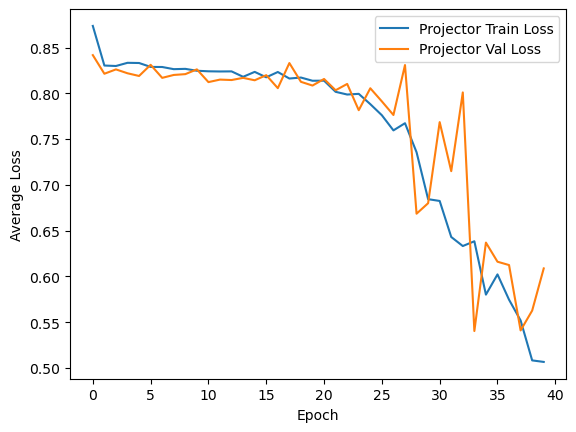

In [34]:
run = training.initWandbRun(
    "", epochs, BATCH_SIZE, projector_num_params, "Adam", "", lr, lr
)

projector_train_loss, projector_val_loss = training.train_model(
    projector, 
    optim,
    apply_projector_model, 
    projector_loss, 
    epochs, 
    train_dataloader, 
    val_dataloader, 
    device, 
    run, 
    scheduler=None, 
    output_name="projector", 
    calc_accuracy=False
)

run.finish()

visualization.plot_loss(epochs,
    {
        "Projector Train Loss": projector_train_loss,
        "Projector Val Loss": projector_val_loss
    }
)

Again, load the best saved weights for the projector model. This time we don't freeze it as we fine tune it inside the final RGB-to-Lidar classifier.

In [35]:
projector = models.Projector(source_embedding_dim, target_embedding_dim)
projector.load_state_dict(torch.load("../checkpoints/projector.pt", map_location=device))
projector = projector.to(device)

## Final RGB-to-Lidar Classifier

In [36]:
rgbToLiderClassifier = models.RGB2LiDARClassifier(projector, cilp_model, lidar_classifier)
rgbToLidar_num_params = sum(p.numel() for p in rgbToLiderClassifier.parameters())

epochs = 30
start_lr = 1e-2
end_lr = 1e-6
optim = torch.optim.Adam(rgbToLiderClassifier.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optim, T_max=epochs * steps_per_epoch, eta_min=end_lr)

In [37]:
def apply_rgb_Lidar_Classifier_model(model, batch):
    inputs_rgb, _, target = batch
    inputs_rgb = inputs_rgb.to(device)
    target = target.to(device)
    outputs = model(inputs_rgb)
    return outputs, target

loss_func = nn.BCEWithLogitsLoss()

All random seeds set to 51 for reproducibility
epoch 0 train loss: 0.5743390780687332
epoch 0 valid loss: 0.5448039323091507 accuracy: 0.7604166666666666
Found and saved better weights for the model
epoch 1 train loss: 0.538498438000679
epoch 1 valid loss: 0.5445467631022135 accuracy: 0.7135416666666666
Found and saved better weights for the model
epoch 2 train loss: 0.5221583539247513
epoch 2 valid loss: 0.5330412114659945 accuracy: 0.7265625
Found and saved better weights for the model
epoch 3 train loss: 0.5402111321687698
epoch 3 valid loss: 0.5593045925100645 accuracy: 0.7213541666666666
epoch 4 train loss: 0.5245636695623398
epoch 4 valid loss: 0.5749457453687986 accuracy: 0.7135416666666666
epoch 5 train loss: 0.5114370161294937
epoch 5 valid loss: 0.5443066681424776 accuracy: 0.7317708333333334
epoch 6 train loss: 0.5106726181507111
epoch 6 valid loss: 0.5525789534052213 accuracy: 0.7265625
epoch 7 train loss: 0.5164810824394226
epoch 7 valid loss: 0.5398495569825172 accuracy: 

learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train_loss,█▆▅▆▆▅▅▅▅▄▄▄▄▄▃▄▃▂▂▂▃▂▂▂▁▁▁▁▁▁
valid_accuracy,▆▁▂▂▁▃▂▄▆▆▆▇▃▆▂▇▆▇██▅▇▇▇▇▇▇▇▇▇
valid_loss,▆▅▅▇█▅▆▅▄▃▄▃▅▂▅▃▂▂▁▁▃▁▁▁▁▁▁▁▁▁
learning_rate,0.0
total_train_time_sec,71.38597
train_loss,0.42897


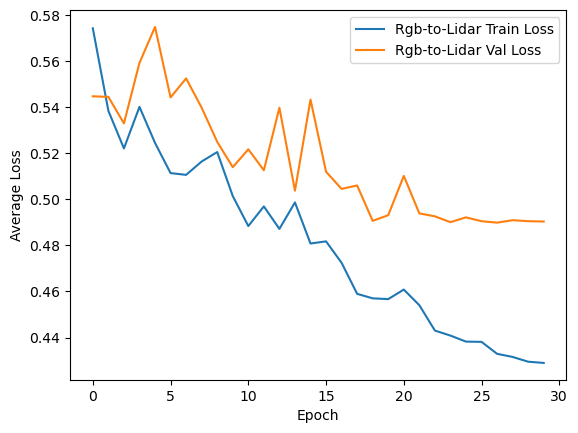

In [38]:
run = training.initWandbRun(
    "", epochs, BATCH_SIZE, rgbToLidar_num_params, "Adam", "", lr, lr
)

final_train_loss, final_val_loss = training.train_model(
    rgbToLiderClassifier, 
    optim,
    apply_rgb_Lidar_Classifier_model, 
    loss_func, 
    epochs, 
    train_dataloader, 
    val_dataloader, 
    device, 
    run, 
    scheduler=scheduler, 
    output_name="rgb_to_lidar_classifier"
)

run.finish()

visualization.plot_loss(epochs,
    {
        "Rgb-to-Lidar Train Loss": final_train_loss,
        "Rgb-to-Lidar Val Loss": final_val_loss
    }
)

In [39]:
rgbToLiderClassifier.eval()
with torch.no_grad():
    batch = next(iter(val_dataloader))
    rgb, lidar_xyza, labels = batch
    rgb = rgb.to(device); lidar_xyza = lidar_xyza.to(device); labels = labels.to(device)

    # True LiDAR path
    true_embs = lidar_classifier.get_embs(lidar_xyza)
    logits_true = lidar_classifier(data_embs=true_embs).squeeze(1)
    acc_true = ((torch.sigmoid(logits_true) >= 0.5) == labels.bool()).float().mean()

    # Projected path
    img_embs = cilp_model.img_embedder(rgb)
    proj_embs = projector(img_embs)
    logits_proj = lidar_classifier(data_embs=proj_embs).squeeze(1)
    acc_proj = ((torch.sigmoid(logits_proj) >= 0.5) == labels.bool()).float().mean()

    # Alignment stats
    cosine = torch.nn.functional.cosine_similarity(proj_embs, true_embs, dim=1).mean()
    norm_true = true_embs.norm(dim=1).mean()
    norm_proj = proj_embs.norm(dim=1).mean()

print(f"Acc true: {acc_true:.3f} | Acc proj: {acc_proj:.3f}")
print(f"Cosine mean: {cosine:.3f} | Norm true: {norm_true:.3f} | Norm proj: {norm_proj:.3f}")


Acc true: 0.969 | Acc proj: 0.531
Cosine mean: 0.559 | Norm true: 1.000 | Norm proj: 1.000
